In [12]:
import json
import numpy as np
import random, math
import copy

def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data
    
CHAR_INDICES = read_json('../models/CHAR_INDICES.json', key_int=False)

In [13]:
# text = "aku|makan"

# look_back = 10
# look_front = 5

# def create_dataset(text, look_back, look_front):
#     X, y = [], []
#     text = '|' + text
#     data = ['?'] * look_back
#     for i in range(1, len(text)):
#         current_char = text[i]
#         before_char = text[i-1]

#         if current_char == '|':
#             continue

#         data = data[1:look_back] + [current_char]  # X data
#         target = 1 if before_char == '|' else 0  # y data

#         # look front
#         j = 0
#         while len(data) < look_back + look_front:
#             if i+j+1 < len(text):
#                 if text[i+j+1] == '|':
#                     j += 1
#                     continue
#                 data.append(text[i+j+1])
#             else:
#                 data.append('?')

#             j += 1

#         X.append(data)
#         y.append(target)
#     y[-1] = 1  # end text is '|'
#     return X, y

# dataX, dataY = create_dataset(text, look_back, look_front)
# for i in range(len(dataX)):
#     print(dataX[i], dataY[i])

### TRAIN TEST & PREPROCESSING

In [14]:
file_train = [
    "../dataset/id_meta_part_1_translate_80000.txt",
    "../dataset/id_meta_part_1_translate_50000.txt",
]

file_test = [
    "../dataset/id_meta_part_1_translate_20000.txt",
]

file_validate = [
    "../dataset/id_meta_part_1_translate_30000.txt",
]

In [15]:
# CREATE DICTIONARY

dict_path = "../models/dictionary.txt"
def create_dict(file_list):
    words = []
    for file in file_list:
        with open(file, 'r') as f:
            delimeter = "|"
            for line in f:
                line = line.strip()
                line = line.split(delimeter)
                for word in line:
                    if word not in words:
                        words.append(word)


    with open(dict_path, 'w') as f:
        for word in words:
            f.write(word + '\n')

    return words

def read_dict():
    with open(dict_path, 'r') as f:
        words = f.read().splitlines()
    return words

DICT = read_dict()

In [16]:
def replace(text, wordlist):
    for new_word, list_ in wordlist.items():
        for old_word in list_:
            text = text.replace(old_word.lower(), new_word)
    
    return text

def preprocessing(text, wordlist):
    text = text.lower()  # to lower-case
    text = replace(text, wordlist)

    # check if char is in CHAR_INDICES
    for char in text:
        if char not in CHAR_INDICES:
            text = text.replace(char, '')
            
    return text

def generate_dict_vector(text):
    vect = [0.0] * len(text)
    for i in range(len(text)):
        current_text = text[:i+1]
        if current_text in DICT:
            vect[i] = 1.0
        else:
            vect[i] = 0.0

    return vect

def create_dataset(text, look_back, look_front):
    X, y = [], []
    X_ngram = []
    text = '|' + text
    data = [CHAR_INDICES['<pad>']] * look_back
    for i in range(1, len(text)):
        current_char = text[i]
        before_char = text[i-1]

        if current_char == '|':
            continue

        data = data[1:look_back] + [CHAR_INDICES[current_char]]  # X data
        target = 1 if before_char == '|' else 0  # y data

        # look front
        front_text = current_char
        j = 0
        while len(data) < look_back + look_front:
            if i+j+1 < len(text):
                if text[i+j+1] == '|':
                    j += 1
                    continue
                data.append(CHAR_INDICES[text[i+j+1]])
                front_text += text[i+j+1]
            else:
                data.append(CHAR_INDICES['<pad>'])
                front_text += '?'

            j += 1
        
        ngram_vector = generate_dict_vector(front_text)
        X_ngram.append(ngram_vector)
        X.append(data)
        y.append(target)
        
    y[-1] = 1  # end text is '|'
    return X, X_ngram, y


def encode_data(X, y):
    sequence_len = len(X[0])
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.float32)
    encode_y = np.zeros((len(y), 2), dtype=np.float32)
    for i, (data, target) in enumerate(zip(X, y)):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
        encode_y[i, target] = 1
        
    return encode_X, encode_y


def read_text(file):
    return open(file, encoding='utf-8', errors="ignore").read()

In [17]:
wordlist = {
    '': ['\n'],
}

wordlist2 = copy.deepcopy(wordlist)
wordlist2[''].append('|')

nb_data_train = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_train)
nb_data_validate = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_validate)
nb_data_test = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_test)

print('Number of data on train set: ', nb_data_train)
print('Number of data on validate set: ', nb_data_validate)
print('Number of data on test set: ', nb_data_test)
print('Number of all data: ', sum([nb_data_train, nb_data_validate, nb_data_test]))

Number of data on train set:  4799194
Number of data on validate set:  2621281
Number of data on test set:  2806109
Number of all data:  10226584


### DATASET GENERATOR

In [23]:
# TEST DATASET
files = file_train
look_back = 10
look_front = 5
copy_files = files.copy()
random.shuffle(copy_files)

for file in copy_files:
    print(f'File: {file}')

    text = read_text(file)
    text = preprocessing(text, wordlist)
    X_data, X_ngram, y_data = create_dataset(text, look_back, look_front)
    print(f'Number of data: {len(X_data)}')
    print(f'Number of ngram: {len(X_ngram)}')
    print(f'Number of target: {len(y_data)}')
    X_data, y_data = encode_data(X_data, y_data)
    print(f'X_data shape: {X_data.shape}')
    print(f'y_data shape: {y_data.shape}')

    break

File: ../dataset/id_meta_part_1_translate_80000.txt


KeyboardInterrupt: 

In [18]:
def generator(files, wordlist, batch_size=1024, look_back=20, look_front=5, mode='Training', display_=False):
    while True:
        copy_files = files.copy()
        random.shuffle(copy_files)

        for file in copy_files:
            if display_ is True:
                print(f'\n{mode} file: ' + file)

            text = read_text(file)
            text = preprocessing(text, wordlist)
            X_data, X_ngram, y_data = create_dataset(text, look_back, look_front)
            print(f'Number of data: {len(X_data)}')
            print(f'Number of ngram: {len(X_ngram)}')
            print(f'Number of target: {len(y_data)}')
            X_data, y_data = encode_data(X_data, y_data)
            print(f'X_data shape: {X_data.shape}')
            print(f'y_data shape: {y_data.shape}')

            samples_per_epoch  = len(X_data)
            number_of_batches = int(math.ceil(samples_per_epoch / batch_size))

            for counter in range(number_of_batches):
                X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
                X_ngram_batch = np.array(X_ngram[batch_size*counter:batch_size*(counter+1)])
                y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
                
                yield [X_batch, X_ngram_batch], y_batch

### MODEL

Total params:  9004


2024-06-20 06:43:58.043314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-20 06:43:58.044787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-20 06:43:58.045921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

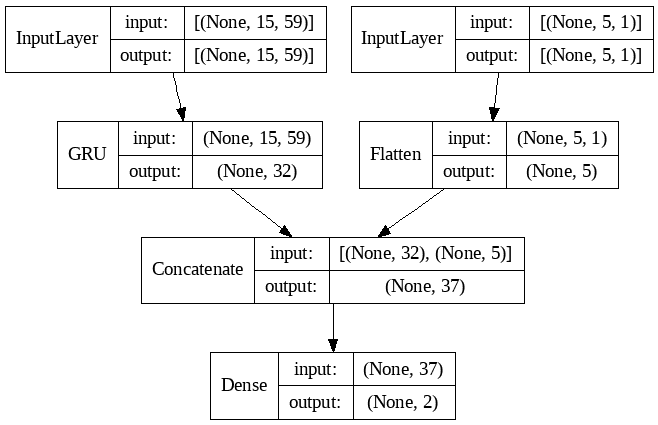

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Bidirectional, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import copy
tf.config.list_physical_devices('GPU')

tf.random.set_seed(42)

LOOK_BACK = 10
LOOK_FRONT = 5
batch_size = 1000
steps_per_epoch = int(nb_data_train / batch_size)
validation_steps = int(nb_data_train / (batch_size * 10))

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Layer, Input, Bidirectional, Concatenate, Flatten

def define_model(input1, input2):
    input1 = Input(shape=input1)
    input2 = Input(shape=input2)
    gru_output = GRU(32, return_sequences=False)(input1)
    flat2 = Flatten()(input2)

    concatenated = Concatenate()([gru_output, flat2])
    output = Dense(2, activation='softmax')(concatenated)
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # compile

    print('Total params: ', model.count_params())
    return model


    # model = Sequential()
    # model.add(Bidirectional(GRU(input1[1]//2, input_shape=input1, return_sequences=False), merge_mode='sum', weights=None, input_shape=input1))
    # model.add(Dense(input1[1]//4, activation='linear'))
    # model.add(Dense(2, activation='softmax'))
    # model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # compile

    # print('Total params: ', model.count_params())
    # return model


input1 = (LOOK_BACK + LOOK_FRONT, len(CHAR_INDICES))
input2 = (LOOK_FRONT, 1)
model = define_model(input1, input2)  # define model

# plot model
image_name = '../images/model.png'
plot_model(model, image_name, show_shapes=True, show_layer_names=False)
display(Image(filename=image_name))

In [20]:
# Generators
training_generator = generator(file_train, 
                               wordlist, 
                               batch_size, 
                               look_back=LOOK_BACK,
                               look_front=LOOK_FRONT, 
                               mode='Training')

validation_generator = generator(file_validate, 
                                 wordlist, 
                                 batch_size, 
                                 look_back=LOOK_BACK, 
                                 look_front=LOOK_FRONT, 
                                 mode='Validation')

print('steps per epoch', steps_per_epoch)
print('validation steps', validation_steps)

steps per epoch 4799
validation steps 479


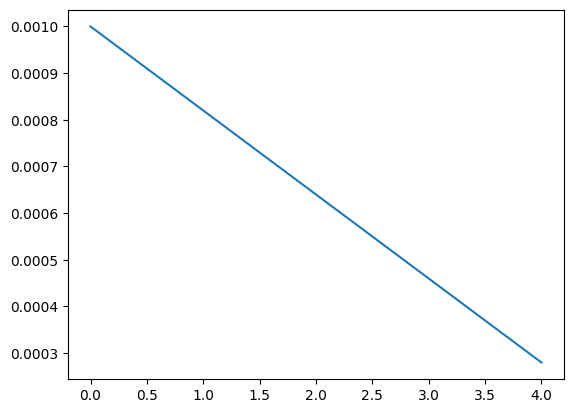

In [21]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from matplotlib import pyplot as plt

# checkpoint
filepath="../models/model-gru-{epoch:03d}-{accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

def step_decay(epoch):
    initial_lrate = 0.001
    min_lrat = 0.0001
    drop_per_epoch = (initial_lrate - min_lrat) / NB_EPOCH
    lrate = initial_lrate - (drop_per_epoch * epoch)
    return lrate

NB_EPOCH = 5
lrate = LearningRateScheduler(step_decay)

plt.plot([step_decay(i) for i in range(NB_EPOCH)]);
plt.savefig('../images/gru-step-decay.png')

In [22]:
callbacks_list = [checkpoint, lrate]

history = model.fit(training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=NB_EPOCH,
                    verbose=1,
                    callbacks=callbacks_list)


KeyboardInterrupt: 

In [11]:
# save history as csv
import pandas as pd
df = pd.DataFrame(history.history)
df.to_csv('../models/history-gru.csv', index=False)